In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [5]:
-6 % 4

2

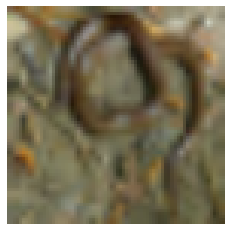

/usr/local/lib/python3.9/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per image: 108


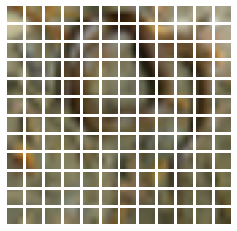

In [329]:
plt.figure(figsize=(4,4))

for x, y in trainloader:
    plt.imshow(x[0].permute(1,2,0))
    plt.axis("off")
    plt.show()

    x = transforms.Resize((image_size, image_size))(x)
    patches = Patches(patch_size=patch_size)(x)
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per image: {patches.shape[-1]}")


    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4,4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = patch.reshape(3, patch_size, patch_size).permute(1,2,0)
        plt.imshow(patch_img.numpy())
        plt.axis('off')
    break


In [2]:
lr = 1e-3
weight_decay = 1e-4
batch_szie = 256
num_epoch = 4
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
project_dim = 64
num_heads = 4
transformer_units = [
    project_dim * 2,
    project_dim
] # size of transformer Layers
transformer_layers = 8
num_classes = 1000
mlp_head_units = [2048, 1024]

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)

In [94]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_szie, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_szie, shuffle=False)


Files already downloaded and verified
50000
Files already downloaded and verified
10000


In [5]:
data_augmentation = transforms.Compose(
    [
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=0.2),
        transforms.RandomResizedCrop(size=(image_size, image_size), )
    ]
)

In [69]:
class MLP_Unit(nn.Module):
    def __init__(self, units, dropout_rate, in_big, in_short):
        super(MLP_Unit, self).__init__()   
        self.layer_short = nn.Linear(in_features=in_short, out_features=units)
        self.layer_long = nn.Linear(in_features=in_big, out_features=units)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activate = nn.GELU()

    def forward(self, x, index):
        if index == 1:
            x = self.layer_long(x)
        else :
            x = self.layer_short(x)
        x = self.activate(x)
        x = self.dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, hidden_units, dropout_rate, in_big, in_short):
        super(MLP, self).__init__()  
        self.mlp_units = []
        for units in hidden_units:
            self.mlp_units.append(MLP_Unit(units=units, dropout_rate=dropout_rate, in_big=in_big, in_short=in_short))

    def forward(self, x):
        for index, mlp_unit in enumerate(self.mlp_units):
            x = mlp_unit(x, index)

        return x

In [70]:
class Patches(nn.Module):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def forward(self, images):
    # 256, 3, 72, 72
    batch = images.size()[0]
    patches = x.unfold(1, 3, 3).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
    patches = patches.squeeze(1)
    patches = patches.resize(batch, 12*12 ,3 * self.patch_size* self.patch_size)
    return patches

In [71]:
class PatchEncoder (nn.Module):
  def __init__(self, num_patches, project_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = nn.Linear(in_features=108, out_features=project_dim)
    self.prostional_embedding = nn.Embedding(num_embeddings=144, embedding_dim=project_dim)

  def forward(self, patch):
    # patch = B x 144 x 108
    positions =  torch.arange(start=0, end=self.num_patches, step=1)
    # positions = 144
    p1 = self.projection(patch)
    # p1 = B x 144 x 64
    p2 = self.prostional_embedding(positions)
    # p2 = 144, 64
    encoded =  p1+p2
    # encoded = B x 144 x 64
    return encoded

In [72]:
class Transformer(nn.Module):
    def __init__(self, transformer_units, normalized_shape, patch_size, in_big=128, in_short=64):
        super(Transformer, self).__init__()
        self.normalized_shape = normalized_shape
        self.norm_1 = nn.LayerNorm(normalized_shape=normalized_shape, eps=1e-6)
        self.norm_2 = nn.LayerNorm(normalized_shape=normalized_shape, eps=1e-1)
        self.mha = nn.MultiheadAttention(embed_dim=project_dim, num_heads=num_heads, dropout=0.1)
        self.mlp = MLP(hidden_units=transformer_units, dropout_rate=0.1,  in_big=in_big, in_short=in_short)


    def forward(self, encoded_patches):
        x1 = self.norm_1(encoded_patches)
        attention_output = self.mha(x1,x1,x1)    
        x2 = attention_output[0] + encoded_patches
        x3 = self.norm_2(x2)
        x3 = self.mlp(x3)
        ret = x3 + x2

        return ret

In [90]:
class ViT(nn.Module):
    def __init__(self, transformer_layers, transformer_units, patch_size, num_patches, project_dim, mlp_head_units, num_classes, normalized_shape):
        super(ViT, self).__init__()
        self.patches = Patches(patch_size=patch_size)
        self.encode_patches = PatchEncoder(num_patches=num_patches, project_dim=project_dim)
        self.norm_1 = nn.LayerNorm(normalized_shape=normalized_shape, eps=1e-6)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(p=0.5)

        self.mlp = MLP(hidden_units=mlp_head_units, dropout_rate=0.5, in_short=9216, in_big=9216//2)

        self.mlp_layer_1 = nn.Linear(in_features=9216, out_features=2048)
        self.mlp_drop_1 = nn.Dropout(p=0.1)
        self.mlp_layer_2 = nn.Linear(in_features=2048, out_features=1024)
        self.mlp_drop_2 = nn.Dropout(p=0.1)

        self.activate = nn.GELU()



        self.lognits = nn.Linear(in_features=1024, out_features=num_classes)

        self.transformers = []
        for i in range(transformer_layers):
            self.transformers.append(Transformer(transformer_units, normalized_shape, patch_size))


    def forward(self, x):
        # x =  B x 3 x 72 x 72
        aug = data_augmentation(x)
        # aug = B x 3 x 72 x 72
        patches = self.patches(aug)
        # patch =  B x 144 x 108
        encode_patches = self.encode_patches(patches)
        # encode_patches = B x 144 x 64

        for t in self.transformers:
            encode_patches = t(encode_patches)
        # encode_patches = B x 144 x 64 

        representation = self.norm_1(encode_patches)
        # representation_1:  torch.Size([256, 144, 64])
        representation = self.flatten(representation)
        # representation_2:  torch.Size([256, 9216])
        representation = self.drop(representation)
        # representation_3:  torch.Size([256, 9216])

        y = self.mlp_layer_1(representation)
        y = self.activate(y)
        y = self.mlp_drop_1(y)

        y = self.mlp_layer_2(y)
        y = self.activate(y)
        y = self.mlp_drop_2(y)

        log = self.lognits(y)
        return log

In [91]:
def accuracy(out, labels):
    return len(out) - torch.count_nonzero(torch.argmax(out, dim=1)- torch.abs(labels))

In [95]:
normalized_shape = (batch_szie, 144, 64)
model = ViT(
    transformer_layers, 
    transformer_units, 
    patch_size, 
    num_patches, 
    project_dim, 
    mlp_head_units, 
    num_classes,
    normalized_shape
)
optim = torch.optim.AdamW(model.parameters(), lr=lr)
history = []
for i in range(num_epoch):
    model.train()
    eps = []
    for batch in trainloader:
        x,y = batch
        out = model(x)
        loss = nn.CrossEntropyLoss()(out, y)
        acc = accuracy(out, y)
        eps.append({'val_loss': loss.item(), 'val_acc': acc.item()})

    batch_losses = [x['val_loss'] for x in eps]
    epoch_loss = np.average(batch_losses)
    batch_accs = [x['val_acc'] for x in eps]
    epoch_acc = np.sum(batch_accs) / 50000.0
    print("train-loss: {:.4f}, train-acc: {:.4f}%".format(epoch_loss, epoch_acc), end=' | ')

    model.eval()
    eps = []
    for batch in testloader:
        x, y = batch
        out = model(x)
        loss = nn.CrossEntropyLoss()(out, y)
        acc = accuracy(out, y)
        eps.append({'val_loss': loss.item(), 'val_acc': acc.item()})

    batch_losses = [x['val_loss'] for x in eps]
    epoch_loss = np.average(batch_losses)
    batch_accs = [x['val_acc'] for x in eps]
    epoch_acc = np.average(batch_accs) / 10000.0
    print("train-loss: {:.4f}, train-acc: {:.4f}".format(epoch_loss, epoch_acc))


/usr/local/lib/python3.9/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
